In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [170]:

def load_csv(filePath, sep=','):
    return pd.read_csv(filePath, sep=sep)

def engineer_features(df):
    df = df.copy()
    # Age in years
    df['age_years'] = df['age'] // 365
    # BMI
    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
    # Pulse pressure
    df['pulse_pressure'] = df['bp_high'] - df['bp_low']
    # Hypertension flag
    df['is_hypertensive'] = ((df['bp_high'] >= 140) | (df['bp_low'] >= 90)).astype(int)
    # Combined metabolic risk
    df['risk_level'] = df['cholesterol'] + df['glucose_level']
    # Drop raw columns used to create features
    df.drop(columns=[
        'age', 'height', 'weight', 'bp_high', 'bp_low', 'cholesterol', 'glucose_level'
    ], inplace=True)
    return df

def split_features_target(df, yColumn, dropColumns):
    X = df.drop(columns=dropColumns + [yColumn])
    y = df[yColumn]
    return X, y

def apply_polynomial(X, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    columns = poly.get_feature_names_out(X.columns if isinstance(X, pd.DataFrame) else None)
    return pd.DataFrame(X_poly, columns=columns)

def apply_scaling(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

def split_data(X, y, test_size=0.4, cv_size=0.5, seed=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=cv_size, random_state=seed)
    return X_train, y_train, X_cv, y_cv, X_test, y_test

def prepare_data(filePath, 
                 yColumn, 
                 csv_sep=',',
                 scale=True,
                 polynomial=False,
                 polyDegree=2,
                 dropColumns=['id']):

    df = load_csv(filePath, sep=csv_sep)

    # Apply feature engineering
    df = engineer_features(df)

    # Drop duplicate drops (prevent appending yColumn every call)
    dropCols = list(dropColumns)  # copy list to avoid side effects
    if yColumn not in dropCols:
        dropCols.append(yColumn)

    X, y = split_features_target(df, yColumn, dropCols)

    if polynomial:
        X = apply_polynomial(X, degree=polyDegree)

    if scale:
        X = apply_scaling(X)

    return split_data(X, y)


In [171]:


X_train, y_train, X_cv, y_cv, X_test, y_test = prepare_data(
    filePath = '../data/sample-files/cardiovascular-disease/cardio_train.csv', 
    yColumn='cardio',
    polynomial=True, 
    polyDegree=2,
    csv_sep=';',
    dropColumns=['id'])

# print(X_train.columns)
print(X_train.shape)
print(y_train.shape)

print(X_cv.shape)
print(y_cv.shape)

print(X_test.shape)
print(y_test.shape)



(42000, 54)
(42000,)
(14000, 54)
(14000,)
(14000, 54)
(14000,)


In [172]:
epochs = 10000

model = LogisticRegressionCV(max_iter=epochs,
                             solver='lbfgs', 
                             penalty='l2',
                             Cs=[0.001, 0.01, 0.1, 1, 10],
                             random_state=42,
                             n_jobs=2, 
                             class_weight='balanced')
model.fit(X_train,y_train)

predictionX = X_train
predictionY = y_train







[0.33862899 0.44869685 0.15862486 ... 0.53632816 0.25890396 0.15058128]
[0 0 0 ... 0 0 0]
Train Accuracy: 0.7210714285714286
CV Accuracy: 0.7221428571428572
Test Accuracy: 0.724


In [178]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, log_loss,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

def evaluate_all_sets(model, X_train, y_train, X_cv, y_cv, X_test, y_test, average='binary'):
    def evaluate_split(X, y, name):
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred

        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average=average)
        rec = recall_score(y, y_pred, average=average)
        f1 = f1_score(y, y_pred, average=average)
        auc = roc_auc_score(y, y_proba)
        loss = log_loss(y, y_proba)

        return {
            'name': name,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'auc': auc,
            'log_loss': loss,
            'y': y,
            'y_pred': y_pred,
            'y_proba': y_proba
        }

    sets = [
        evaluate_split(X_train, y_train, "Train"),
        evaluate_split(X_cv, y_cv, "CV"),
        evaluate_split(X_test, y_test, "Test")
    ]

    # Print metrics table
    print(f"{'Set':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10} {'LogLoss':<10}")
    print("="*65)
    for s in sets:
        print(f"{s['name']:<8} {s['accuracy']:<10.4f} {s['precision']:<10.4f} {s['recall']:<10.4f} "
              f"{s['f1']:<10.4f} {s['auc']:<10.4f} {s['log_loss']:<10.4f}")

    # Plot confusion matrices
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for i, s in enumerate(sets):
        cm = confusion_matrix(s['y'], s['y_pred'])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axs[i], colorbar=False)
        axs[i].set_title(f"{s['name']} Set")
    plt.tight_layout()
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for s in sets:
        RocCurveDisplay.from_predictions(s['y'], s['y_proba'], name=s['name']).plot(ax=plt.gca())
    plt.title("ROC Curve - All Sets")
    plt.grid()
    plt.show()

def check_error_percentage(y_hats, true_y):
    comparison = pd.DataFrame({
    "Predicted": y_hats,
    "Actual": true_y
})
    comparison["Match"] = comparison["Predicted"] == comparison["Actual"]

    accuracy_percent = comparison["Match"].mean() * 100
    error_percent = 100 - accuracy_percent

    print(f"✅ Matched: {accuracy_percent:.2f}%")
    print(f"❌ Mismatched: {error_percent:.2f}%")

[0.33862899 0.44869685 0.15862486 ... 0.53632816 0.25890396 0.15058128]
[0 0 0 ... 1 0 0]
✅ Matched: 72.11%
❌ Mismatched: 27.89%
Train Accuracy: 0.7210714285714286
CV Accuracy: 0.7221428571428572
Test Accuracy: 0.724
(40, 54)
range(0, 40)


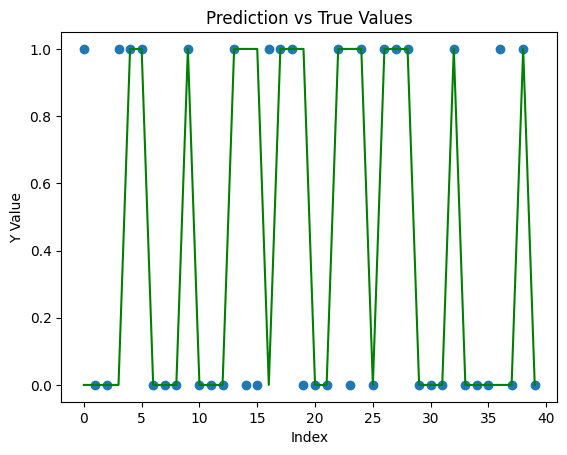

Set      Accuracy   Precision  Recall     F1         AUC        LogLoss   
Train    0.7211     0.7348     0.6885     0.7109     0.7767     0.5668    
CV       0.7221     0.7333     0.6957     0.7140     0.7748     0.5681    
Test     0.7240     0.7439     0.6927     0.7174     0.7811     0.5625    


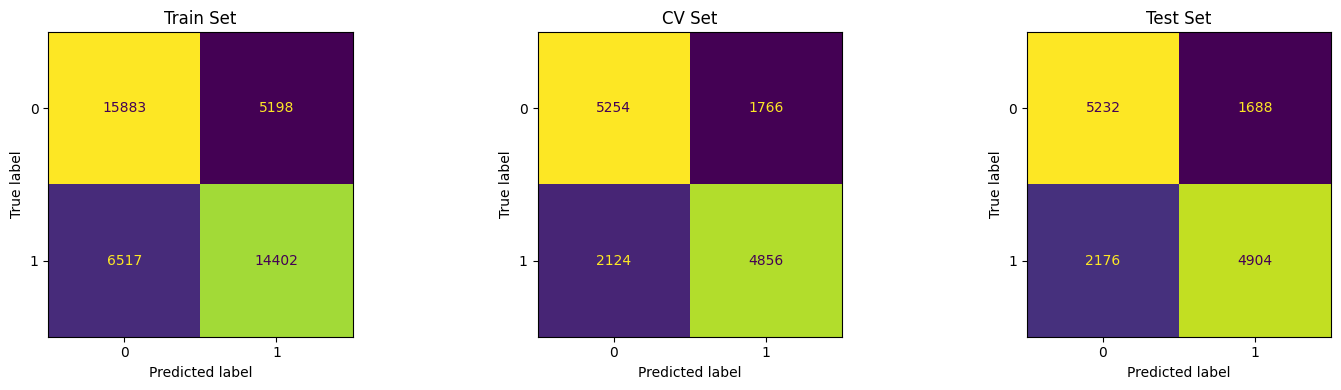

<Figure size 800x600 with 0 Axes>

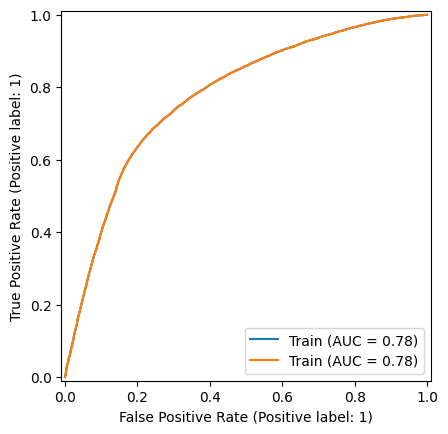

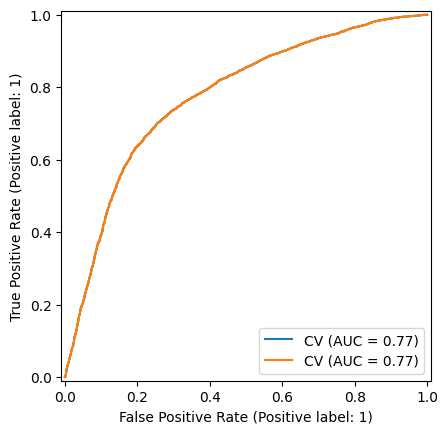

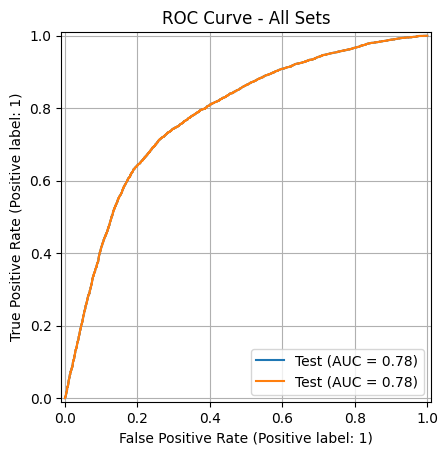

In [184]:
threshold = 0.5
# y_hats = model.predict(predictionX)
y_probs = model.predict_proba(X_train)[:, 1]
y_hats = (y_probs >= threshold).astype(int)




print(y_probs)
print(y_hats)

check_error_percentage(y_hats,y_train)
print("Train Accuracy:", model.score(X_train, y_train))
print("CV Accuracy:", model.score(X_cv, y_cv))
print("Test Accuracy:", model.score(X_test, y_test))

plottingSample = 40

print(X_train[:plottingSample].shape)
print(range(plottingSample))

plt.scatter(range(plottingSample), y_train[:plottingSample].to_numpy(), label='True Y')
# plt.scatter(range(plottingSample), y_hats[:plottingSample],color='red' )
plt.plot(range(plottingSample), y_hats[:plottingSample], label='Predicted Y (Line)', color='green')
plt.title('Prediction vs True Values')
plt.xlabel('Index')
plt.ylabel('Y Value')
# plt.legend()
plt.show()


evaluate_all_sets(model, X_train, y_train, X_cv, y_cv, X_test, y_test)
